<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/BAF_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import glob
import os

# Load Bank Account Fraud (BAF) Tabular Dataset Suite

In [27]:
dir_path = '/content/drive/MyDrive/Mirthe Supervision Map /Paper 3a: FC Bias Disco/BAF'

'''if os.path.exists(dir_path):
    print("Directory exists")
    print("Files in directory:")
    print(os.listdir(dir_path))  # This will list all files in the directory
else:
    print("Directory does not exist")'''

#The parquet extensions allow for smaller file sizes (approx. 3 times smaller) and quicker load speeds

extension = "csv" #"parquet" depending on the downloaded file
data_paths = glob.glob(f"{dir_path}/*.{extension}")

'''# Check if any CSV files are found
if not data_paths:
    raise FileNotFoundError(f"No files with extension '{extension}' found in the directory.")
else:
    print("CSV files found:")
    print(data_paths)'''

def read_dataset(path, ext = extension):
    #return pd.read_csv(path)
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_excel(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [29]:
#print(dataframes)

In [31]:
base = dataframes['Base'] # sampled to best represent original dataset
variant1 = dataframes['Variant I'] # higher group size disparity than base
variant2 = dataframes['Variant II'] # higher prevalance disparity than base
variant3 = dataframes['Variant III'] # better separability of one of the groups
variant4 = dataframes['Variant IV'] # higher prevalance disparity in train
variant5 = dataframes['Variant V'] # better separability in train for one of the groups
#base.info()
variant1.info()
#base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [30]:
'fraud_bool' in base.columns
'fraud_bool' in variant1.columns
'fraud_bool' in variant2.columns
'fraud_bool' in variant3.columns
'fraud_bool' in variant4.columns
'fraud_bool' in variant5.columns

True

In [58]:
base.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [59]:
#variant1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.560867,0.290389,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.494652,0.288847,5.024707e-08,0.226846,0.492220,0.755838,1.000000
prev_address_months_count,1000000.0,16.960120,43.870653,-1.000000e+00,-1.000000,-1.000000,15.000000,399.000000
current_address_months_count,1000000.0,83.585392,86.458280,-1.000000e+00,18.000000,50.000000,124.000000,429.000000
customer_age,1000000.0,31.974200,10.897167,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.051720,5.462110,1.373749e-08,0.007151,0.015104,0.026185,76.635022
intended_balcon_amount,1000000.0,8.715090,20.210541,-1.573989e+01,-1.180401,-0.828224,6.215877,113.120051
zip_count_4w,1000000.0,1574.468789,1003.700453,1.000000e+00,893.000000,1270.000000,1952.000000,6678.000000
velocity_6h,1000000.0,5661.914760,3010.869604,-1.741097e+02,3431.170414,5299.991908,7692.312342,16817.838935


In [61]:
variant2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.574544,0.288768,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.488628,0.291431,5.024707e-08,0.214787,0.489745,0.754373,1.000000
prev_address_months_count,1000000.0,14.824523,43.231383,-1.000000e+00,-1.000000,-1.000000,-1.000000,399.000000
current_address_months_count,1000000.0,99.381393,94.558757,-1.000000e+00,26.000000,64.000000,154.000000,429.000000
customer_age,1000000.0,41.304140,13.804710,1.000000e+01,30.000000,50.000000,50.000000,90.000000
days_since_request,1000000.0,0.911917,4.986861,3.112791e-08,0.007430,0.015650,0.026928,76.577505
intended_balcon_amount,1000000.0,8.638806,20.573558,-1.573989e+01,-1.178013,-0.831185,0.078508,112.702504
zip_count_4w,1000000.0,1567.400554,1009.619023,1.000000e+00,901.000000,1236.000000,1909.000000,6650.000000
velocity_6h,1000000.0,5685.095489,3001.707767,-1.741097e+02,3470.243411,5408.425641,7653.990129,16801.339834


In [55]:
(base['fraud_bool'] == 1).sum()

11029

In [56]:
(variant1['fraud_bool'] == 1).sum()

11029

In [64]:
(variant5['fraud_bool'] == 1).sum()

11030

<Axes: xlabel='fraud_bool', ylabel='income'>

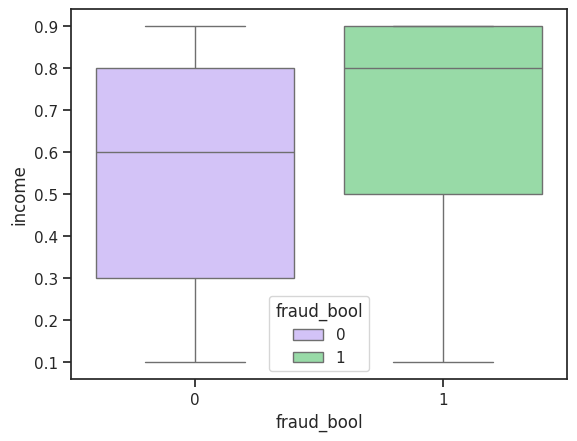

In [42]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=variant1, x = 'fraud_bool', y= 'income', hue = "fraud_bool", palette = ["m", "g"])

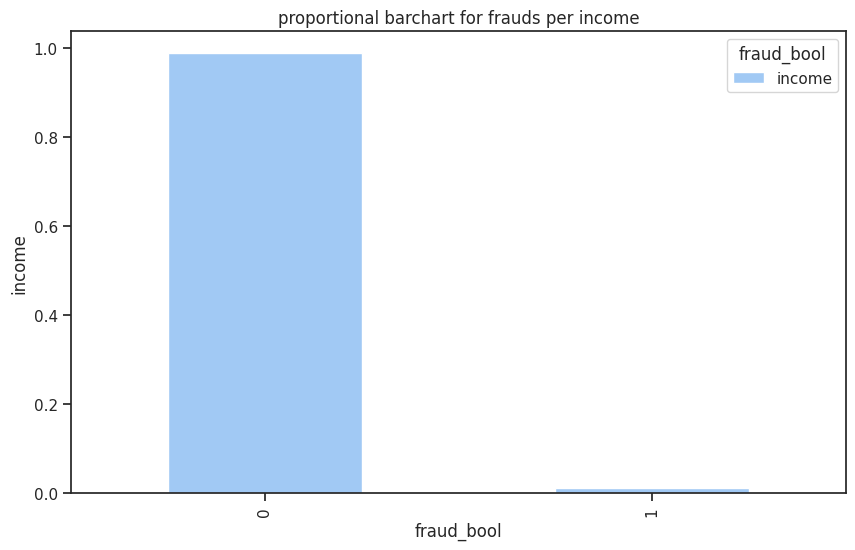

In [47]:
income_fraud_count = variant1.groupby('fraud_bool')['income'].count()
income_fraud_proportions = income_fraud_count.div(income_fraud_count.sum())
income_fraud_proportions.plot(kind = 'bar', figsize=(10, 6))

plt.title('proportional barchart for frauds per income')
plt.xlabel('fraud_bool')
plt.ylabel('income')
plt.legend(title = 'fraud_bool', loc= 'upper right')

plt.show()

<Axes: xlabel='fraud_bool', ylabel='customer_age'>

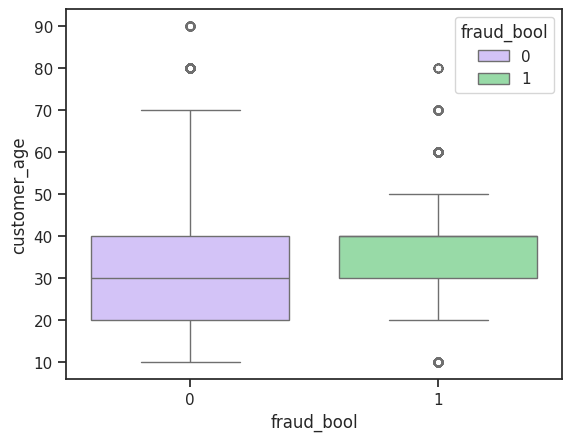

In [44]:
sns.boxplot(data=variant1, x = 'fraud_bool', y= 'customer_age', hue = "fraud_bool", palette = ["m", "g"])

# **Possible preprocessing steps:**

-Handling missing values

-Getting rid of redundant features

-Converting objects to integers

-Grouping aka one hot (dummy) encoding

binning certain features together

-Deciding on distance measures (euclidean, manhattan, gower)

-Scaling

-how to ‘measure’ error: variance vs mean vs accuracy, 1 vs rest, 1 vs best, 1 to 1

-min points and epsilon in DBSCAN

-model choice clustering


# Handling missing values

In [6]:
'''base_no_mv= base.dropna()
#base_no_mv.info()

base_no_mv = base_no_mv[base_no_mv['prev_address_months_count'] != -1]
base_no_mv.info()

print(base_no_mv['prev_address_months_count'])
'''

"base_no_mv= base.dropna()\n#base_no_mv.info()\n\nbase_no_mv = base_no_mv[base_no_mv['prev_address_months_count'] != -1]\nbase_no_mv.info()\n\nprint(base_no_mv['prev_address_months_count'])\n"

# One-hot-encode categorical features for collecting the errors
scaling or one-hot-encoding

In [7]:
Categorical_cols = base.select_dtypes(include=['object']).columns
print(Categorical_cols)

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')


In [8]:
print(base['payment_type'].unique())
print(base['employment_status'].unique())
print(base['housing_status'].unique())
print(base['source'].unique())
print(base['device_os'].unique())

['AA' 'AD' 'AB' 'AC' 'AE']
['CB' 'CA' 'CC' 'CF' 'CD' 'CE' 'CG']
['BC' 'BE' 'BD' 'BA' 'BB' 'BF' 'BG']
['INTERNET' 'TELEAPP']
['linux' 'other' 'windows' 'x11' 'macintosh']


In [9]:
base_onehot = pd.get_dummies(base, Categorical_cols)
print(base_onehot['payment_type_AA'].unique())

[ True False]


# TRAIN

In [10]:
X_base = base_onehot.drop(['fraud_bool'], axis =1)
Y_base = base_onehot['fraud_bool']

In [11]:
X_base_train, X_base_test, Y_base_train, Y_base_test = train_test_split(X_base, Y_base, test_size=0.2, shuffle = True, stratify = Y_base) # Corrected the order of variables returned by train_test_split
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_base_train, Y_base_train)

Y_base_hat = model.predict(X_base_test)
accuracy = accuracy_score(Y_base_test, Y_base_hat)
print("Accuracy:", accuracy)

Accuracy: 0.988985


Collect errors

[[197793      1]
 [  2202      4]]


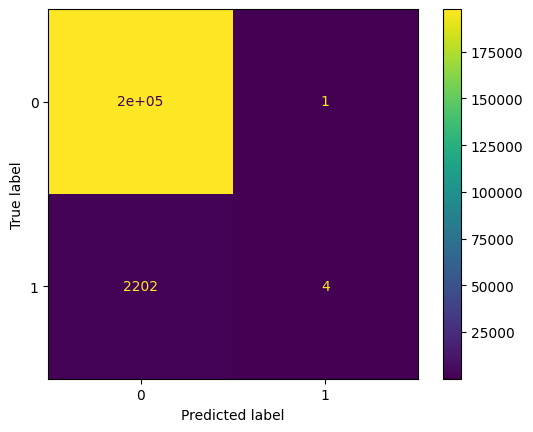

In [20]:
predictions = pd.DataFrame()
predictions['predicted_class'] = Y_base_hat.tolist()
predictions = predictions.set_index(X_base_test.index)
predictions['true_class'] = Y_base_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
base_onehot_error = X_base_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = base_onehot_error['errors']
df_out = base_onehot_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
base_onehot_error[base_onehot_error['errors']==1]

cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [49]:
(base_onehot_error['errors'] == 1).sum()

2203